##Подключение бибилиотек и загрузка данных

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
!wget https://accuracy.wunderfund.io/quant_accuracy_t_2030.csv.gz -O quant_accuracy_t_2030.csv.gz

--2022-03-12 10:02:38--  https://accuracy.wunderfund.io/quant_accuracy_t_2030.csv.gz
Resolving accuracy.wunderfund.io (accuracy.wunderfund.io)... 104.21.12.195, 172.67.195.161, 2606:4700:3034::ac43:c3a1, ...
Connecting to accuracy.wunderfund.io (accuracy.wunderfund.io)|104.21.12.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39819301 (38M) [application/gzip]
Saving to: ‘quant_accuracy_t_2030.csv.gz’

quant_accuracy_t_20 100%[===================>]  37.97M  74.2MB/s    in 0.5s    

2022-03-12 10:02:39 (74.2 MB/s) - ‘quant_accuracy_t_2030.csv.gz’ saved [39819301/39819301]



In [ ]:
trades = pd.read_csv("quant_accuracy_t_2030.csv.gz")
trades.head()

,time,side,price,amount
0,1600992000070695,0,218950,773
1,1600992000070695,0,218950,1000
2,1600992000072200,0,218955,2012
3,1600992000072200,0,218970,40
4,1600992000072200,0,218970,14


##Предобработка

Группируем данные, так как есть строки с одинаковым временем и ценой

In [ ]:
trades = trades.groupby(by=['time', 'price', 'side']).agg({"amount":"sum"}).reset_index()
trades.head()

,time,price,side,amount
0,1600992000070695,218950,0,1773
1,1600992000072200,218955,0,2012
2,1600992000072200,218970,0,54
3,1600992000072200,218990,0,419
4,1600992000073816,218990,0,628


Разделим данные

In [ ]:
trades.shape[0]

4835948

In [ ]:
num_shape = 4800000

train = trades.iloc[:num_shape, 1:2].values
test = trades.iloc[num_shape:, 1:2].values

train.shape, test.shape

((4800000, 1), (35948, 1))

Масштабируем данные

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
sc.fit_transform(trades.iloc[:, 1:2].values)

train_scaled = sc.transform(train)

Разбиваем ряд окном по 35 элементво

In [ ]:
X = []
Y = []

window = 35

for i in range(window, num_shape):
    X_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X.append(X_)
    Y.append(train_scaled[i, 0])
    
X = np.stack(X)
Y = np.stack(Y)

In [ ]:
X.shape, Y.shape

((4799965, 35, 1), (4799965,))

##Модель, обучение

In [ ]:
model = Sequential()

model.add(LSTM(units = 64, return_sequences = True, input_shape = (X.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 64))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(X[int(X.shape[0] * 0.97):], 
          Y[int(X.shape[0] * 0.97):], 
          epochs = 2,
          batch_size = 4)

12000/12000 [==============================] - 240s 20ms/step - loss: 2.2856e-06


Прогноз на тестовой выборке

In [ ]:
inputs = trades.iloc[trades.shape[0] - test.shape[0] - window:, 1:2].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

num_2 = trades.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [ ]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

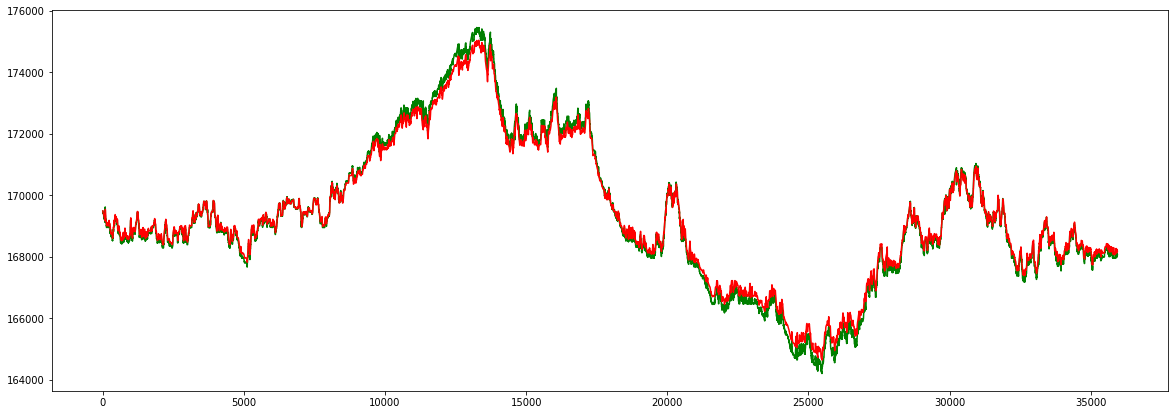

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(test, color = 'green')
plt.plot(predict - (predict[0] - test[0]), color = 'red')
plt.show()

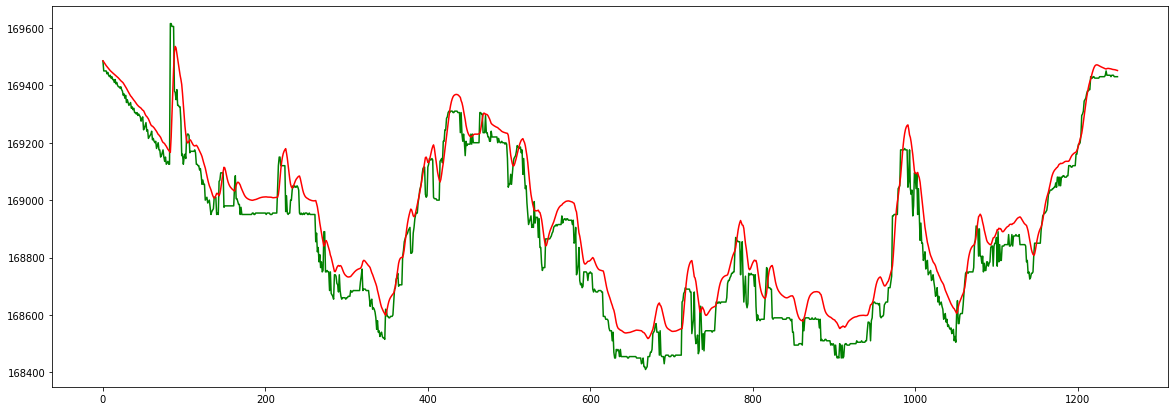

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(test[:1250], color = 'green')
plt.plot(predict[:1250] - (predict[0] - test[0]), color = 'red')
plt.show()

In [ ]:
diff = predict - test

print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MAE: 219.4311570706298
RMSE: 257.5742729891699


In [ ]:
target = [0 if predict[i] < predict[i+1] else 1 for i in range(predict.size-1)]

In [ ]:
roc_auc_score(trades.iloc[num_shape:-1, 2:3].values, target)

0.7214020314982807